In [702]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [703]:
import numpy as np
import pandas as pd

In [704]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [705]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import and_
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, String

In [706]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [707]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [708]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [709]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [710]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [711]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

# Exploratory Climate Analysis

In [712]:
# Get a list of column names and types for station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [713]:
# Get a list of column names and types for measurment table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [714]:
# Latest Date on record in string format
last_measurement_date = session.query(Measurement.date).\
                           order_by(Measurement.date.desc()).first()[0]
last_measurement_date

'2017-08-23'

In [715]:
# Break down the latest date into interget year, month and day components
last_measurement_year = int(last_measurement_date[0:4])
last_measurement_month = int(last_measurement_date[5:7])
last_measurement_day = int(last_measurement_date[8:11])

In [716]:
# Get the date 12 months ago from the lasest date on record
last_year = dt.date(last_measurement_year, last_measurement_month, last_measurement_day) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [717]:
# Retrieve the last 12 months of precipitation data.
last_12_months_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).\
    filter(and_(Measurement.date) <= last_measurement_date)

In [718]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(last_12_months_prcp[:], columns = ["date", "prcp"]).dropna()
prcp_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [719]:
# Sort the DataFrame values by `date`
prcp_df.set_index('date').head()

# Rename columns for graph legend
prcp_df.columns = ["Date", "Precipitation"]
prcp_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


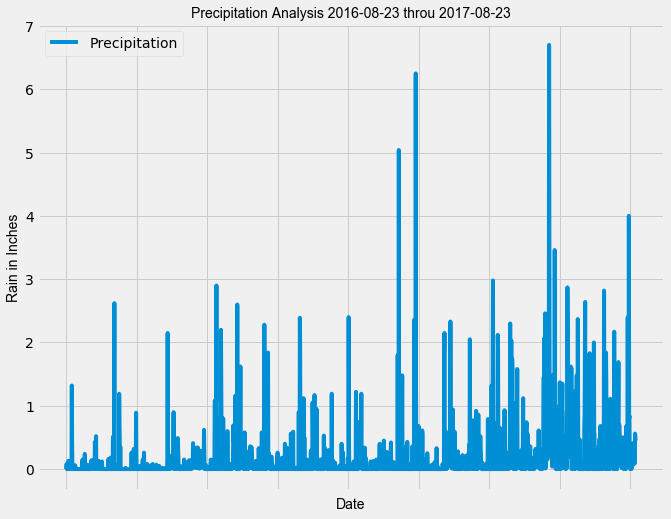

In [720]:
# Plot the results
prcp_df.plot("Date", "Precipitation", figsize=(10,8))
plt.xlabel("Date", fontname='Arial', fontsize=14)
plt.ylabel("Rain in Inches", fontname='Arial', fontsize=14)
title_txt = "Precipitation Analysis " + str(last_year) + " throu " + str(last_measurement_date)
plt.title(title_txt, fontname='Arial', fontsize=14)

# Save Figure
plt.draw()
plt.savefig("precipitation.png", dpi=100)
plt.show()

In [721]:
# Use Pandas to print the summary statistics for the precipitation data.
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [722]:
# How many stations are available in this dataset?
number_of_stations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(number_of_stations))

There are 9 stations.


In [753]:
# What are the most active stations?
most_active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.tobs).desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
busiest_df = pd.DataFrame(most_active_stations[:], columns = ["name", "tobs"]).dropna()
busiest_df.head()

,name,tobs
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [760]:
busist = busiest_df.loc[busiest_df["tobs"].idxmax()]
print("The most active station is " + busist["name"] + " with total of " +
      str(busist["tobs"]) + " observations" )

The most active station is USC00519281 with total of 2772 observations


In [761]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

busiest_df.describe()

,tobs
count,9.000000
mean,2172.222222
std,777.073963
min,511.000000
25%,1979.000000
50%,2612.000000
75%,2709.000000
max,2772.000000


In [600]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [601]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [602]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [603]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [604]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [605]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [606]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [607]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [608]:
# Plot the daily normals as an area plot with `stacked=False`
